In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from solowModel_cython import SolowModel

In [3]:
# Set up the simulation batch parameters
params = dict(tech0=1, rho=1 / 3, epsilon=1e-5, tau_y=1000, dep=0.0002,
              tau_h=25, tau_s=250, c1=1, c2=3.1e-4, gamma=2000, beta1=1.1,
              beta2=1.0, saving0=0.15, h_h=10)

xi_args = dict(decay=0.2, diffusion=2.0)
start = np.array([1, 10, 9, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params=params, xi_args=xi_args)
sm.simulate(start, t_end=1e7, seed=40)
sm.visualise()

KeyboardInterrupt: 

In [ ]:
# Set up the simulation batch parameters
params = dict(tech0=1, rho=1 / 3, epsilon=1e-5, tau_y=1000, dep=0.0002,
              tau_h=25, tau_s=250, c1=1, c2=4e-4, gamma=2000, beta1=1.1,
              beta2=1.0, saving0=0.15, h_h=10)

xi_args = dict(decay=0.2, diffusion=2.0)
start = np.array([1, 10, 9, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params=params, xi_args=xi_args)
sm.simulate(start, t_end=1e7, seed=40)
sm.visualise()

In [ ]:
# Set up the simulation batch parameters
params = dict(tech0=1, rho=1 / 3, epsilon=1e-5, tau_y=1000, dep=0.0002,
              tau_h=25, tau_s=250, c1=1, c2=2e-4, gamma=2000, beta1=1.1,
              beta2=1.0, saving0=0.15, h_h=10)

xi_args = dict(decay=0.2, diffusion=2.0)
start = np.array([1, 10, 9, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params=params, xi_args=xi_args)
sm.simulate(start, t_end=1e7, seed=40)
sm.visualise()

# Asymptotic Analysis

### Helper Functions

In [4]:
def name_extractor(filename):
    temp = filename.split('_')
    g = 'g_'+str(int(temp[2][1:]))
    c2 = 'c2_'+str(float(temp[7]))
    e = 'e_'+str(float(temp[3][1:]))
    return '_'.join([g,c2,e])

In [5]:
def extract_g_c2(filename, string=False):
    parts = filename.split('_')
    # locate g
    for i,part in enumerate(parts):
        if part[0] == 'g' and part[1]!='e':
            gamma = int(part[1:])
        if part == 'c2':
            c2 = float(parts[i+1])
    if string:
        "g_{}_c2_{:.1e}".format(gamma,c2)
    else:
        return (gamma, c2)

In [6]:
def analysis(sims, c2_list, gamma_list):
    df_g = pd.DataFrame(index=sorted(c2_list), columns = sorted(gamma_list))
    df_div = pd.DataFrame(index=sorted(c2_list), columns = sorted(gamma_list))
    df_yks = pd.DataFrame(index=sorted(c2_list), columns = sorted(gamma_list))
    df_y_check = pd.DataFrame(index=sorted(c2_list), columns = sorted(gamma_list))
    
    for g in gamma_list:
        for c2 in c2_list:
            if (g,c2) in sims.keys():
                df = sims[(g, c2)]
                df_g.loc[c2,g]=df.g.mean()
                df_div.loc[c2,g]=(df.psi_ks - df.psi_kd).mean()
                df_yks.loc[c2,g]=(df.psi_ks - df.psi_y).mean()
                df_y_check.loc[c2,g] = np.tanh(g*df.psi_y.mean())
    for df in [df_g, df_div, df_yks]:
        df.index.name='c2'
        df.columns.name='Gamma'
        df = df.astype(float)
        df.index = [float(i) for i in df.index]
    return df_g, df_div, df_yks, df_y_check

### Result frames

In [22]:
sims_e6 = {}
folder = 'asymptotics/'
for path in os.listdir(folder):
    if ".df" in path and "t1e+06" in path:
        file = open(folder+path, 'rb')
        sims_e6[extract_g_c2(path)] = pickle.load(file)
        file.close()

gamma_list = sorted(list(set([g[0] for g in sims_e6.keys()])))
c2_list = sorted(list(set([g[1] for g in sims_e6.keys()])))
c2_list = [i for i in c2_list if i not in [0.00015,0.00025,0.00035,0.00045]]

In [23]:
sims = {}
folder = 'asymptotics/'
for path in os.listdir(folder):
    if ".df" in path and "t1e+07" in path:
        file = open(folder+path, 'rb')
        sims[extract_g_c2(path)] = pickle.load(file)
        file.close()
        
gamma_list = sorted(list(set([g[0] for g in sims.keys()])))
c2_list = sorted(list(set([g[1] for g in sims.keys()])))
c2_list = [i for i in c2_list if i not in [0.00015,0.00025,0.00035,0.00045]]

In [24]:
df_g_e6, df_div_e6, df_yks_e6, df_y_check_e6 = analysis(sims_e6, c2_list, gamma_list)

In [25]:
df_g, df_div, df_yks, df_y_check = analysis(sims, c2_list, gamma_list)

In [26]:
for df in [df_g, df_div, df_yks]:
    df.index.name='c2'
    df.columns.name='Gamma'
    df = df.astype(float)
    df.index = [float(i) for i in df.index]

### Visuals - The Constant G

In [27]:
def heatmap(df, label, title, save='', scatter=None):
    y_l = ['{:.1e}'.format(float(i)) for i in df_div.index]
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(12,8)
    sns.heatmap(df.astype(float), cmap='coolwarm', cbar_kws={'label': label}, 
                yticklabels=y_l, xticklabels=2, linewidths=.1, ax=ax)
    if isinstance(scatter, list):
        x,y = scatter
        ax.plot([i+0.5 for i in x], [i+0.5 for i in y], color='black', marker='x', linewidth=3.0)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis='x', labelrotation= 0)
    ax.invert_yaxis()
    plt.tight_layout()
    if save != '':
        plt.savefig(save+'.png', bbox_inches='tight')
    plt.show()

In [28]:
def divergence_loc(cutoff, df_div):
    q = df_div[df_div<cutoff].astype(float).idxmax(axis=1).dropna()
    g, c2 = list(df_div.columns), list(df_div.index)
    x = [g.index(i) for i in q]
    y = [c2.index(i) for i in q.index]
    return [x, y]

In [29]:
def divergence_g(cutoff, df_div, df_g):
    div_coords = divergence_loc(cutoff, df_div)
    g_approx = []
    for loc in zip(div_coords[1], div_coords[0]):
        g_approx.append(df_g.iloc[loc])
    return np.mean(g_approx), np.std(g_approx)

In [30]:
b1, b2 = 1.1, 1.0
def h_max(b1, b2):
    return (2/(3*b2*(b1**1.5)))*((b1-1)**1.5)

In [43]:
print(h_max(1.1, 0.7), h_max(1.1, 0.9), h_max(1.1, 1.0))
print(h_max(1.1, 1.0), h_max(1.2, 1.0), h_max(1.3, 1.0))

0.026104878318421124 0.02030379424766087 0.018273414822894782
0.018273414822894782 0.04536092116265143 0.07390530175619407


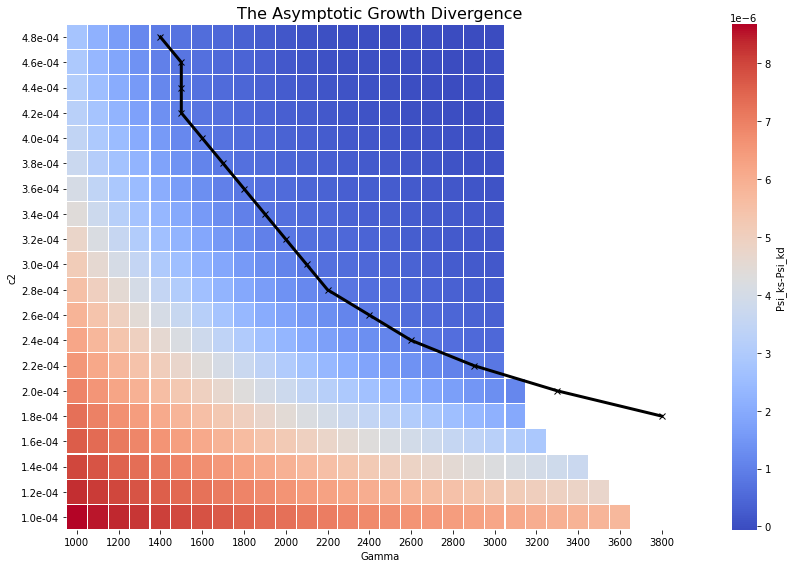

In [31]:
heatmap(df_div.mask(df_y_check>h_max(1.2,1.0)), 'Psi_ks-Psi_kd', 'The Asymptotic Growth Divergence', '', 
        divergence_loc(1e-6, df_div))

g         7.647129e-01
upper     8.322561e-01
lower     6.971697e-01
cutoff    1.000000e-10
Name: 100, dtype: float64


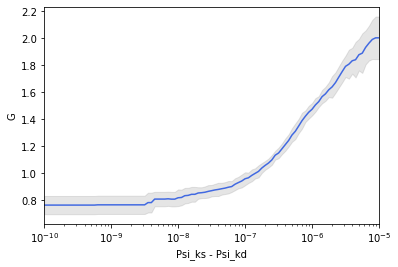

In [33]:
df_div_g = pd.DataFrame(index = np.arange(101), columns = ['g', 'upper', 'lower','cutoff'], dtype=float)
for i, cutoff in enumerate(np.logspace(-5,-10, 101)):
    m, s = divergence_g(cutoff, df_div, df_g)
    df_div_g.iloc[i,:] = [m, m+s, m-s, cutoff]

print(df_div_g.iloc[-1,:])
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(df_div_g.cutoff, df_div_g.g, color='royalblue')
ax.set_xlim(df_div_g.cutoff.min(), df_div_g.cutoff.max())
plt.fill_between(df_div_g.cutoff, df_div_g.lower, df_div_g.upper, alpha = 0.2, color='gray')
ax.set_xlabel('Psi_ks - Psi_kd')
ax.set_ylabel('G')
plt.show()

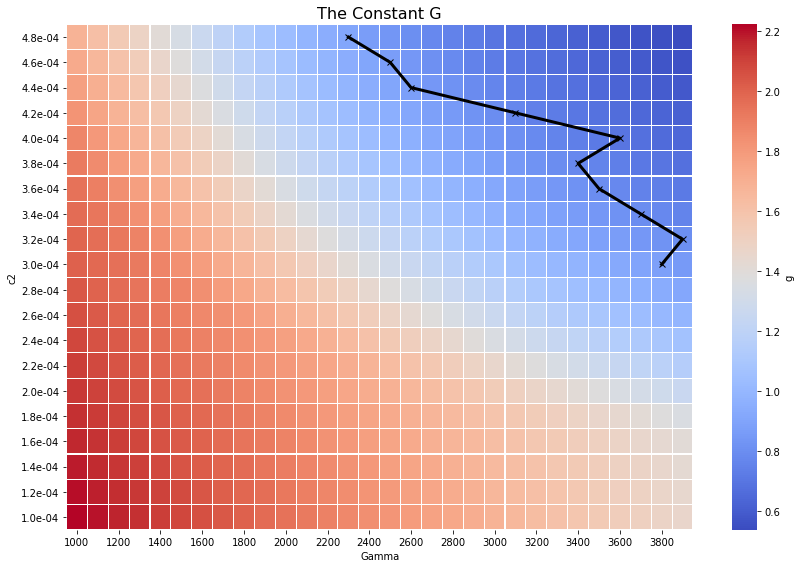

In [34]:
heatmap(df_g, 'g', 'The Constant G', 'figures/fig_constant_g', divergence_loc(1e-8, df_div))

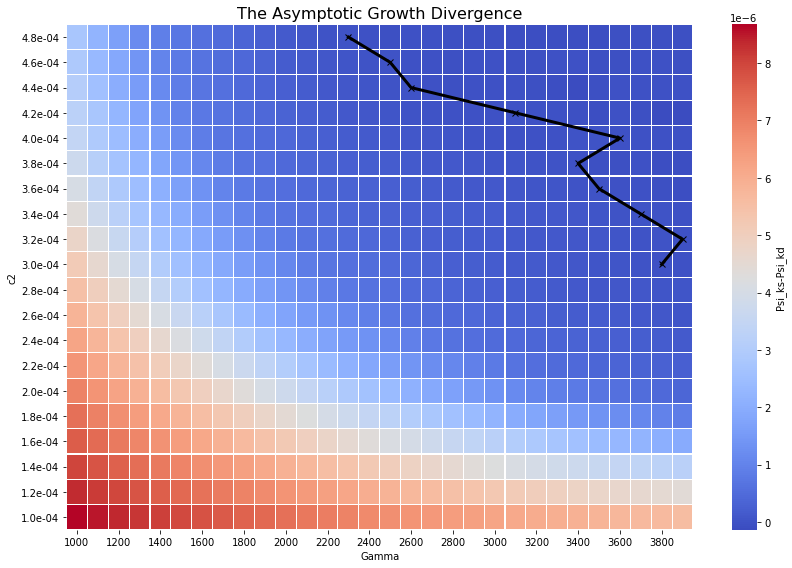

In [35]:
heatmap(df_div, 'Psi_ks-Psi_kd', 'The Asymptotic Growth Divergence', 'figures/fig_psiks-psikd', 
        divergence_loc(1e-8, df_div))

In [38]:
df_y_check.max()

1000    0.013738
1100    0.015420
1200    0.017117
1300    0.018802
1400    0.020419
1500    0.021993
1600    0.023544
1700    0.025076
1800    0.026614
1900    0.028154
2000    0.029703
2100    0.031227
2200    0.032731
2300    0.034241
2400    0.035748
2500    0.037260
2600    0.038744
2700    0.040232
2800    0.041739
2900    0.043241
3000    0.044720
3100    0.046234
3200    0.047742
3300    0.049267
3400    0.050770
3500    0.052282
3600    0.053786
3700    0.055275
3800    0.056764
3900    0.058266
dtype: float64

In [42]:
from itertools import product
q = dict(gamma=[1000,2000,3000],c2=[1e-4,2e-4],b1=[1.1,1.2,1.3])
for i in product(*list(q.values())):
    print(i)

(1000, 0.0001, 1.1)
(1000, 0.0001, 1.2)
(1000, 0.0001, 1.3)
(1000, 0.0002, 1.1)
(1000, 0.0002, 1.2)
(1000, 0.0002, 1.3)
(2000, 0.0001, 1.1)
(2000, 0.0001, 1.2)
(2000, 0.0001, 1.3)
(2000, 0.0002, 1.1)
(2000, 0.0002, 1.2)
(2000, 0.0002, 1.3)
(3000, 0.0001, 1.1)
(3000, 0.0001, 1.2)
(3000, 0.0001, 1.3)
(3000, 0.0002, 1.1)
(3000, 0.0002, 1.2)
(3000, 0.0002, 1.3)
